# Result Analysis of the Car Network

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

def validFiles(files):
    validFiles = []
    for file in files:
        if os.path.exists(file):
            validFiles.append(file)
    return validFiles

## Read Sim Results

In [2]:
simFolder = "."

sufE2E = "_E2EDelay.json"
sufPubCreated = "_PubCreated.json"
sufSubCreated = "_SubCreated.json"
sufPubRemotes = "_PubRemotes.json"
sufSubRemotes = "_SubRemotes.json"
sufSwitchIdleSlopes = "_SwitchIdleSlopes.json"
sufSwitchQueueDelay = "_SwitchQueueDelay.json"
sufSwitchQueueLength = "_SwitchQueueLength.json"

scenarios = [
    "CMI_B250",
    # "CMI_B500",
    # "CMI_B1000",
    "SI-",
    "Dyrectsn",
    "SI_NoSDScatter"
]

def getScenarioFromFileName(fileName):
    if "NoSDScatter" in fileName:
        return "SI_NoSDScatter"
    for scenario in scenarios:
        if scenario in fileName:
            return scenario
    return None

### Bandwidth Reservation

In [3]:
isFiles = []
for scenario in scenarios:
    isFiles.append(simFolder + "/" + scenario + sufSwitchIdleSlopes)
isFiles = validFiles(isFiles)
print(isFiles)

['./CMI_B250_SwitchIdleSlopes.json', './SI-_SwitchIdleSlopes.json', './Dyrectsn_SwitchIdleSlopes.json', './SI_NoSDScatter_SwitchIdleSlopes.json']


In [61]:
def getNodeFromModule (module):
    return module.split(".")[1]

def getPortFromModule (module):
    return int(module.split(".")[2].split("[")[1].split("]")[0])

def getPCPFromModule (module):
    return int(module.split(".")[-1].split("[")[1].split("]")[0])

def isModuleWithPcp(module, pcp):
    return getPCPFromModule(module) == pcp

def getAllIdleSlopesForSimStudy(simFile):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                port = getPortFromModule(module)
                pcp = getPCPFromModule(module)
                if node not in results:
                    results[node] = dict()
                if port not in results[node]:
                    results[node][port] = dict()
                results[node][port][pcp] = vector["value"][-1] # last value
    return results

def addSumToIdleSlopeVector(idleSlopes):
    for node in idleSlopes:
        for port in idleSlopes[node]:
            sum = 0
            for pcp in idleSlopes[node][port]:
                sum += idleSlopes[node][port][pcp]
            idleSlopes[node][port]["Total"] = sum
    return idleSlopes

def getMinIdleSlope(idleSlopes, pcp, ignoreZero = False):
    min = 1000000000
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if idleSlopes[node][port][pcp] < min:
                if ignoreZero and idleSlopes[node][port][pcp] <= 0:
                    continue
                min = idleSlopes[node][port][pcp]
    return min

def getMaxIdleSlope(idleSlopes, pcp):
    max = 0
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if idleSlopes[node][port][pcp] > max:
                max = idleSlopes[node][port][pcp]
    return max

def getAvgIdleSlope(idleSlopes, pcp):
    sum = 0
    count = 0
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if pcp == "Total":
                added = False
                if idleSlopes[node][port][4] > 0:
                    sum += idleSlopes[node][port][4]/1000000
                    added = True
                if idleSlopes[node][port][5] > 0:
                    sum += idleSlopes[node][port][5]/1000000
                    added = True
                if added:
                    count += 1                    
            elif idleSlopes[node][port][pcp] > 0:
                    sum += idleSlopes[node][port][pcp]/1000000
                    count += 1
    return (sum / count) * 1000000

In [57]:
idleSlopes = dict()
for file in isFiles:
    scenario = getScenarioFromFileName(file)
    idleSlopes[scenario] = getAllIdleSlopesForSimStudy(file)
    idleSlopes[scenario] = addSumToIdleSlopeVector(idleSlopes[scenario])
print(idleSlopes)

{'CMI_B250': {'switchFrontLeft': {0: {4: 170240000, 5: 128640000, 'Total': 298880000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 398240000, 5: 0, 'Total': 398240000}, 4: {4: 118560000, 5: 0, 'Total': 118560000}}, 'switchFrontRight': {0: {4: 188480000, 5: 314112000, 'Total': 502592000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 364800000, 5: 0, 'Total': 364800000}}, 'switchRearLeft': {0: {4: 21280000, 5: 314112000, 'Total': 335392000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 139840000, 5: 0, 'Total': 139840000}}, 'switchRearRight': {0: {4: 240160000, 5: 0, 'Total': 240160000}, 1: {4: 0, 5: 885504000, 'Total': 885504000}, 2: {4: 319200000, 5: 0, 'Total': 319200000}, 3: {4: 0, 5: 0, 'Total': 0}}, 'switchCenter': {0: {4: 389120000, 5: 0, 'Total': 389120000}, 1: {4: 364800000, 5: 0, 'Total': 364800000}, 2: {4: 319200000, 5: 756864000, 'Total': 1076064000}, 3: {4: 139840000, 5: 0, 'Total': 139840000}}}, 'SI-': {'switchFro

In [58]:
# print idle slopes larger than 800000000
for scenario in idleSlopes:
    print(scenario)
    for node in idleSlopes[scenario]:
        for port in idleSlopes[scenario][node]:
            for pcp in idleSlopes[scenario][node][port]:
                value = idleSlopes[scenario][node][port][pcp]/1000000
                if value > 1000:
                    # print in red
                    print("\033[91m", node, port, pcp, value, "\033[0m")
                elif value > 800:
                    print(node, port, pcp, value, " with ", 1000 - value, "left to 1Gbps")

CMI_B250
switchRearRight 1 5 885.504  with  114.49599999999998 left to 1Gbps
switchRearRight 1 Total 885.504  with  114.49599999999998 left to 1Gbps
 switchCenter 2 Total 1076.064 
SI-
Dyrectsn
 switchRearRight 1 5 2212.453517 
 switchRearRight 1 Total 2212.453517 
 switchCenter 2 5 1816.838948 
 switchCenter 2 Total 2217.452263 
SI_NoSDScatter


In [60]:
outfile = "tab_car_idleslopes.tex"
with open(outfile, "w") as f:
    f.write("%!TEX root = ../main.tex\n")
    f.write("\\begin{tabularx}{\linewidth}{l l Y Y Y}\n")
    f.write("\\toprule\n")
    f.write("Reservation Scheme & PCP & \\multicolumn{3}{c}{Idle Slope [\si{\mega\\bit\per\second}]} \\\\\n")
    f.write(" & & Min & Avg & Max \\\\\n")
    f.write("\\midrule\n")
    pcps = [4,5,"Total"]
    for scenario in idleSlopes:
        if "Scatter" in scenario:
            continue
        for pcp in pcps:
            min = getMinIdleSlope(idleSlopes[scenario], pcp, True) / 1000000
            max = getMaxIdleSlope(idleSlopes[scenario], pcp) / 1000000
            avg = getAvgIdleSlope(idleSlopes[scenario], pcp) / 1000000
            # print as a latex booktabs table
            scenarioPrint = scenario.replace("_", " ").replace("CMI", "\codeword{Fixed CMI}").replace("SI-", "\codeword{Flow interval}").replace("Dyrectsn", "\codeword{Delay Budget}")
            if "B" in scenario:
                scenarioPrint = scenarioPrint.replace(" B250", "")
            f.write(scenarioPrint + " & " + str(pcp) + " & $" + format(min,".2f") + "$ & $" + format(avg,".2f") + "$ & $" + format(max,".2f") + "$ \\\\\n")
    f.write("\\bottomrule\n")
    f.write("\\end{tabularx}\n")

### Switch Bandwidth over Time

In [8]:
print(idleSlopes[scenario]["switchRearRight"][1])

{4: 0, 5: 785476924, 'Total': 785476924}


In [9]:
switchPortsOfInterest = {
    "switchRearRight": 1, #'0A-AA-00-00-00-16',
    "switchCenter": 2, #'0A-AA-00-00-00-1B',
}

def createPairVector(vector1, vector2):
    if len(vector1) != len(vector2):
        print("Error: vectors have different lengths")
        return None
    pairVector = []
    for i in range(len(vector1)):
        pairVector.append((vector1[i], vector2[i]))
    return pairVector

def removeLeadingZerosFromPairVector(pairVector):
    for i in range(len(pairVector)):
        if pairVector[i][1] != 0:
            return pairVector[i:]
    return None

def splitPairVector(pairVector):
    x = []
    y = []
    if pairVector == None:
        return x, y
    for pair in pairVector:
        x.append(pair[0])
        y.append(pair[1])
    return x, y

def getIdleSlopeVectorFor(simFile, switch, port):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                nodePort = getPortFromModule(module)
                pcp = getPCPFromModule(module)
                if node == switch and nodePort == port:
                    if pcp not in results:
                        results[pcp] = dict()    
                    results[pcp]["time"], results[pcp]["value"] = splitPairVector(removeLeadingZerosFromPairVector(createPairVector(vector["time"],vector["value"])))
    return results
        
def getIdleSlopeAtOrBefore(time, idleSlopeVector):
    if idleSlopeVector == None or len(idleSlopeVector["time"]) == 0:
        return None
    for i in range(len(idleSlopeVector["time"])):
        if idleSlopeVector["time"][i] == time:
            return idleSlopeVector["value"][i]
        elif idleSlopeVector["time"][i] > time:
            if i > 0:
                return idleSlopeVector["value"][i-1]
            else:
                return None            
    return idleSlopeVector["value"][-1]

def addTotalToIdleSlopeVector(idleSlopeVector):
    # we have to align the time vectors, so the total represents always the sum at each time one of the PCPs is updated
    times = []
    totalLength = 0
    pcpLengths = dict()
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            times += idleSlopeVector[pcp]["time"]
            pcpLengths[pcp] = len(idleSlopeVector[pcp]["time"])
            totalLength += pcpLengths[pcp]
    times = list(set(times))
    times.sort()
    if "Total" not in idleSlopeVector:
        idleSlopeVector["Total"] = dict()
        idleSlopeVector["Total"]["time"] = []
        idleSlopeVector["Total"]["value"] = []
    for time in times:
        sum = 0
        for pcp in idleSlopeVector:
            if idleSlopeVector[pcp] != None and pcp != "Total":
                value = getIdleSlopeAtOrBefore(time, idleSlopeVector[pcp])
                if value != None:
                    sum += value
        idleSlopeVector["Total"]["time"].append(time)
        idleSlopeVector["Total"]["value"].append(sum)
    print("Time total length: ", totalLength, "PCP lengths: ", pcpLengths, "result total length: ", len(idleSlopeVector["Total"]["time"]))
    return idleSlopeVector

def getTMinAndTMax(idleSlopeVector):
    max = 0
    min = 1000000000
    for time in idleSlopeVector["Total"]["time"]:
        if time > max:
            max = time
        if time < min:
            min = time
    return min, max

def getTMinAndTMaxForAll(switchPortsOfInterest):
    tMin = 1000000000
    tMax = 0
    for scenario in switchPortsOfInterest:
        for switch in switchPortsOfInterest[scenario]:
            min, max = getTMinAndTMax(switchPortsOfInterest[scenario][switch])
            if min < tMin:
                tMin = min
            if max > tMax:
                tMax = max
    return tMin, tMax

def addTMinAndTMax(idleSlopeVector, tMin, tMax):
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            if tMin not in idleSlopeVector[pcp]["time"]:
                # add tMin to the front
                idleSlopeVector[pcp]["time"] = [tMin] + idleSlopeVector[pcp]["time"]
                idleSlopeVector[pcp]["value"] = [0] + idleSlopeVector[pcp]["value"]
            if tMax not in idleSlopeVector[pcp]["time"]:
                idleSlopeVector[pcp]["time"].append(tMax)
                idleSlopeVector[pcp]["value"].append(idleSlopeVector[pcp]["value"][-1])
    return idleSlopeVector

def addTMinAndTMaxForAllScenarios(switchPortsOfInterest):
    tMin, tMax = getTMinAndTMaxForAll(switchPortsOfInterest)
    for scenario in switchPortsOfInterest:
        for switch in switchPortsOfInterest[scenario]:
            switchPortsOfInterest[scenario][switch] = addTMinAndTMax(switchPortsOfInterest[scenario][switch], tMin, tMax)
    return switchPortsOfInterest

In [10]:
soiIdleSlopeVecs = dict()
for file in isFiles:
    scenario = getScenarioFromFileName(file)
    soiIdleSlopeVecs[scenario] = dict()
    for switch in switchPortsOfInterest:
        port = switchPortsOfInterest[switch]
        soiIdleSlopeVecs[scenario][switch + "-" + str(port)] = addTotalToIdleSlopeVector(getIdleSlopeVectorFor(file, switch, port))
print(soiIdleSlopeVecs)

Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  110
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  110
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  115 PCP lengths:  {4: 110, 5: 5} result total length:  113
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  5
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  80
{'CMI_B250': {'switchRearRight-1': {4: {'time': [], 'value': []}, 5: {'time': [0.093283276488, 0.095244466018, 0.09543656340000001, 0.096675261365, 0.096924505888, 0.09746975775399999], 'value': [185472000, 314112000, 442752000, 628224000, 756864000, 885504000]}, 'Total': {'time': [0.093283276488, 0.095244466018, 0.09543656340000001, 0.096675261365, 0.096924505888, 0.09746975775399999], 'va

In [11]:
soiIdleSlopeVecs = addTMinAndTMaxForAllScenarios(soiIdleSlopeVecs)
print(soiIdleSlopeVecs)
# for scenario in soiIdleSlopeVecs:
#     for switch in soiIdleSlopeVecs[scenario]:
#         for pcp in soiIdleSlopeVecs[scenario][switch]:
#             print(soiIdleSlopeVecs[scenario][switch][pcp]["time"][-1])

{'CMI_B250': {'switchRearRight-1': {4: {'time': [0.0907275845, 0.10104712381999999], 'value': [0, 0]}, 5: {'time': [0.0907275845, 0.093283276488, 0.095244466018, 0.09543656340000001, 0.096675261365, 0.096924505888, 0.09746975775399999, 0.10104712381999999], 'value': [0, 185472000, 314112000, 442752000, 628224000, 756864000, 885504000, 885504000]}, 'Total': {'time': [0.0907275845, 0.093283276488, 0.095244466018, 0.09543656340000001, 0.096675261365, 0.096924505888, 0.09746975775399999, 0.10104712381999999], 'value': [0, 185472000, 314112000, 442752000, 628224000, 756864000, 885504000, 885504000]}}, 'switchCenter-2': {4: {'time': [0.0907275845, 0.091124531254, 0.091152763468, 0.091159478601, 0.09120791510699999, 0.091483351201, 0.091563481765, 0.091649212996, 0.091664825854, 0.091674553944, 0.091821134645, 0.09190430328799999, 0.09198483025399999, 0.092004271165, 0.092046080694, 0.092168580227, 0.092178955486, 0.092204419165, 0.092235852565, 0.092311487165, 0.092338522051, 0.092354864607,

In [12]:
tMin, tMax = getTMinAndTMaxForAll(soiIdleSlopeVecs)
print(tMin, tMax)

0.0907275845 0.10104712381999999


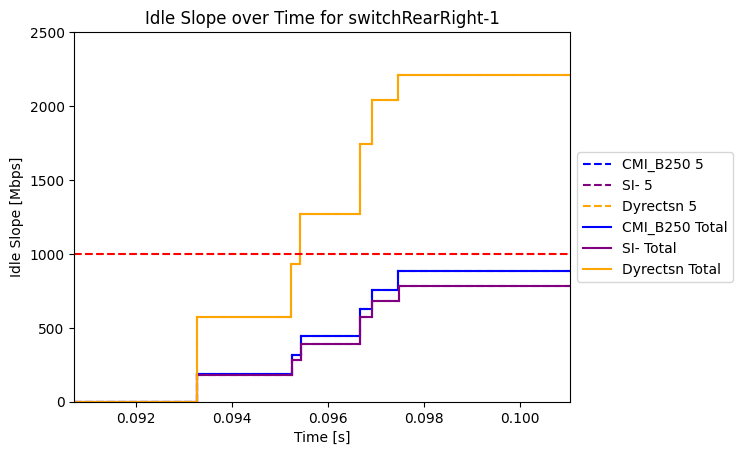

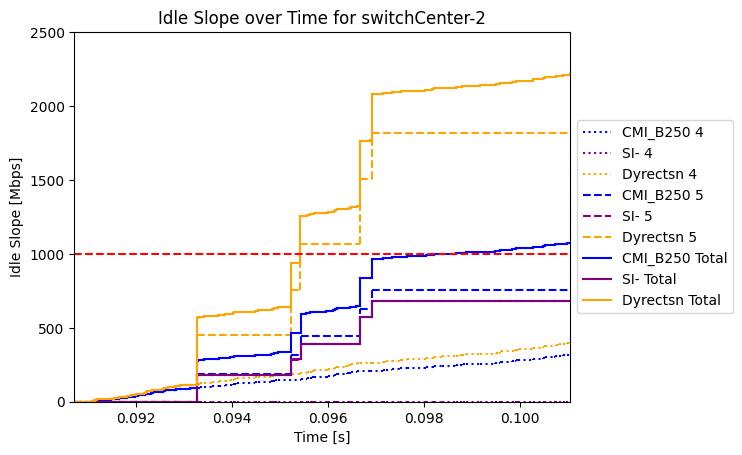

In [13]:
scenarioColors = {
    "CMI_B250": "blue",
    "CMI_B500": "green",
    "CMI_B1000": "yellow",
    "SI-": "purple",
    "Dyrectsn": "orange",
    "SI_NoSDScatter": "black"
}

pcpLine = {
    4: "dotted",
    5: "dashed",
    "Total": "solid"
}

tMin, tMax = getTMinAndTMaxForAll(soiIdleSlopeVecs)
switch = "switchCenter-2"
firstScenario = list(soiIdleSlopeVecs.keys())[0]
# plot the soiIdleSlopeVecs for each switch, separate the two switch ports into two subplots
for switch in soiIdleSlopeVecs[firstScenario]:
    fig, ax = plt.subplots()
    for pcp in soiIdleSlopeVecs[scenario][switch]:
        for scenario in soiIdleSlopeVecs:
            if "Scatter" in scenario or "1000" in scenario:
                continue
            x = soiIdleSlopeVecs[scenario][switch][pcp]["time"]
            if len(x) <= 2:
                continue
            y = [val / 1000000 for val in soiIdleSlopeVecs[scenario][switch][pcp]["value"]]
            # plot as a stair case plot
            for i in range(len(x)-1):
                ax.plot([x[i], x[i+1]], [y[i], y[i]], color=scenarioColors[scenario], linestyle=pcpLine[pcp])
                ax.plot([x[i+1], x[i+1]], [y[i], y[i+1]], color=scenarioColors[scenario], linestyle=pcpLine[pcp])
            # add a label to the legend
            ax.plot([0, 0], [0, 0], color=scenarioColors[scenario], label=scenario + " " + str(pcp), linestyle=pcpLine[pcp])
    # plot a red line at 1 gbit/s
    ax.axhline(y=1000, color='r', linestyle='--')  
    ax.set_xlim(tMin, tMax)      
    ax.set_ylim(0, 2500)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Idle Slope [Mbps]")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Idle Slope over Time for " + switch)
    plt.show()

In [14]:
def getMaxLengthOfIdleSlopeVector(idleSlopeVector):
    maxLength = 0
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            if len(idleSlopeVector[pcp]["time"]) > maxLength:
                maxLength = len(idleSlopeVector[pcp]["time"])
    return maxLength

def getMaxLengthOfAllIdleSlopeVectors(soiIdleSlopeVecs):
    maxLength = 0
    for scenario in soiIdleSlopeVecs:
        for switch in soiIdleSlopeVecs[scenario]:
            length = getMaxLengthOfIdleSlopeVector(soiIdleSlopeVecs[scenario][switch])
            if length > maxLength:
                maxLength = length
    return maxLength

switch = "switchCenter-2"
outfile = switch + "_idleslopes.csv"
with open(outfile, 'w') as csv:
    # compile header:
    line = ""
    first = True
    for scenario in soiIdleSlopeVecs:
        if "Scatter" in scenario or "1000" in scenario:
            continue
        for pcp in soiIdleSlopeVecs[scenario][switch]:
            if first:
                first = False
            else:
                line += ", "
            line += scenario.replace("-","") + "_" + str(pcp) + "_time, " + scenario.replace("-","") + "_" + str(pcp) + "_value"
            print("\\addplot [thick, no markers] table [x=" + scenario.replace("-","")  + "_" + str(pcp) + "_time, y=" + scenario.replace("-","")  + "_" + str(pcp) + "_value, col sep=comma] {data/car/"+ outfile + "};")
    csv.write(line + "\n")
    # compile data:
    maxLength = getMaxLengthOfAllIdleSlopeVectors(soiIdleSlopeVecs)
    for i in range(maxLength):
        line = ""
        first = True
        for scenario in soiIdleSlopeVecs:
            if "Scatter" in scenario or "1000" in scenario:
                continue
            for pcp in soiIdleSlopeVecs[scenario][switch]:
                if first:
                    first = False
                else:
                    line += ", "
                if i < len(soiIdleSlopeVecs[scenario][switch][pcp]["time"]):
                    line += str(soiIdleSlopeVecs[scenario][switch][pcp]["time"][i]) + ", " + str(soiIdleSlopeVecs[scenario][switch][pcp]["value"][i])
                else:
                    line += ", "
        csv.write(line + "\n")
    

\addplot [thick, no markers] table [x=CMI_B250_4_time, y=CMI_B250_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B250_5_time, y=CMI_B250_5_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B250_Total_time, y=CMI_B250_Total_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=SI_4_time, y=SI_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=SI_5_time, y=SI_5_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=SI_Total_time, y=SI_Total_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=Dyrectsn_4_time, y=Dyrectsn_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=Dyrectsn_5_time, y=Dyrectsn_5_value, col sep=comma] {data/

### Setup Time
**.services[*].startTime = 0.09s + initial delay of 0 - 10 ms

finished = max(endpointCreatedAt, connectedRemotes)

setup time = finished - startTime

In [15]:
subCreatedFiles = []
pubCreatedFiles = []
subConnectedRemotesFiles = []
pubConnectedRemotesFiles = []
for scenario in scenarios:
    subCreatedFiles.append(simFolder + "/" + scenario + sufSubCreated)
    pubCreatedFiles.append(simFolder + "/" + scenario + sufPubCreated)
    subConnectedRemotesFiles.append(simFolder + "/" + scenario + sufSubRemotes)
    pubConnectedRemotesFiles.append(simFolder + "/" + scenario + sufPubRemotes)
subCreatedFiles = validFiles(subCreatedFiles)
pubCreatedFiles = validFiles(pubCreatedFiles)
subConnectedRemotesFiles = validFiles(subConnectedRemotesFiles)
pubConnectedRemotesFiles = validFiles(pubConnectedRemotesFiles)
print(subCreatedFiles)
print(pubCreatedFiles)
print(subConnectedRemotesFiles)
print(pubConnectedRemotesFiles)

['./CMI_B250_SubCreated.json', './SI-_SubCreated.json', './Dyrectsn_SubCreated.json', './SI_NoSDScatter_SubCreated.json']
['./CMI_B250_PubCreated.json', './SI-_PubCreated.json', './Dyrectsn_PubCreated.json', './SI_NoSDScatter_PubCreated.json']
['./CMI_B250_SubRemotes.json', './SI-_SubRemotes.json', './Dyrectsn_SubRemotes.json', './SI_NoSDScatter_SubRemotes.json']
['./CMI_B250_PubRemotes.json', './SI-_PubRemotes.json', './Dyrectsn_PubRemotes.json', './SI_NoSDScatter_PubRemotes.json']


In [16]:
def getLastSubCreated(simFile):
    sim = pd.read_json(simFile)
    lastSubCreated = 0
    study = list(sim.keys())[0]
    for scalar in sim[study]["scalars"]:
        if "middleware.subscriberEndpoints" not in scalar["module"]:
            continue
        if "endpointCreated" in scalar["name"]:
            if scalar["value"] > lastSubCreated:
                lastSubCreated = scalar["value"]
    return lastSubCreated

def getLastPubCreated(simFile):
    sim = pd.read_json(simFile)
    lastPubCreated = 0
    study = list(sim.keys())[0]
    for scalar in sim[study]["scalars"]:
        if "middleware.publisherEndpoints" not in scalar["module"]:
            continue
        if "endpointCreated" in scalar["name"]:
            if scalar["value"] > lastPubCreated:
                lastPubCreated = scalar["value"]
    return lastPubCreated

def getLastPubConnectedRemotes(simFile):
    sim = pd.read_json(simFile)
    lastPubRemotes = 0
    study = list(sim.keys())[0]
    for vector in sim[study]["vectors"]:
        if "middleware.publisherEndpoints" not in vector["module"]:
            continue
        if "connectedRemotes" in vector["name"]:
            lastPubRemotes = np.max([np.max(vector["time"]),lastPubRemotes])
    return lastPubRemotes

In [17]:
lastSubsCreated = dict()
for file in subCreatedFiles:
    scenario = getScenarioFromFileName(file)
    lastSubsCreated[scenario] = getLastSubCreated(file)
print(lastSubsCreated)
lastPubsCreated = dict()
for file in pubCreatedFiles:
    scenario = getScenarioFromFileName(file)
    lastPubsCreated[scenario] = getLastPubCreated(file)
print(lastPubsCreated)
lastPubConnectedRemotes = dict()
for file in pubConnectedRemotesFiles:
    scenario = getScenarioFromFileName(file)
    lastPubConnectedRemotes[scenario] = getLastPubConnectedRemotes(file)
print(lastPubConnectedRemotes)

{'CMI_B250': 0.10105542912, 'SI-': 0.10105518892, 'Dyrectsn': 0.101055266334, 'SI_NoSDScatter': 0.092161589}
{'CMI_B250': 0.1008346682, 'SI-': 0.10083475071999999, 'Dyrectsn': 0.100831883134, 'SI_NoSDScatter': 0.09097927800000001}
{'CMI_B250': 0.1008388482, 'SI-': 0.10083893072, 'Dyrectsn': 0.100836211134, 'SI_NoSDScatter': 0.091901917}


In [18]:
start = 0.09
setupTimes = dict()
for scenario in lastSubsCreated:
    lastCreated = np.max([lastSubsCreated[scenario], lastPubsCreated[scenario], lastPubConnectedRemotes[scenario]])
    setupTimes[scenario] = lastCreated - start
    print(scenario, format(setupTimes[scenario]*1000, ".1f"), "ms")

CMI_B250 11.1 ms
SI- 11.1 ms
Dyrectsn 11.1 ms
SI_NoSDScatter 2.2 ms


## Latency

In [19]:
latencyFiles = []
for scenario in scenarios:
    latencyFiles.append(simFolder + "/" + scenario + sufE2E)
latencyFiles = validFiles(latencyFiles)
print(latencyFiles)

['./CMI_B250_E2EDelay.json', './SI-_E2EDelay.json', './Dyrectsn_E2EDelay.json', './SI_NoSDScatter_E2EDelay.json']


In [44]:
def getServiceNum (module):
    return int(module.split(".")[-1].split("[")[1].split("]")[0])

def getServiceName (attributes):
    return attributes["moduledisplaypath"].split(".")[-1]

def findPCPForServiceName (serviceName):
    if "SAuto" in serviceName or "SManual" in serviceName:
        # print("Service ", serviceName, " has PCP 7")
        return 7
    if "SVideo" in serviceName or "SLidar" in serviceName:
        # print("Service ", serviceName, " has PCP 6")
        return 6
    # print ("Service ", serviceName, " has PCP 5")
    return 5

def getEndToEndLatencies(simFile, pcp=None):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "rxLatency" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                service = getServiceNum(module)
                serviceName = getServiceName(vector["attributes"])
                if pcp != None and pcp != findPCPForServiceName(serviceName):
                    continue
                if node not in results:
                    results[node] = dict()
                if service not in results[node]:
                    results[node][service] = dict()
                results[node][service]["name"] = serviceName
                results[node][service]["time"] = vector["time"]
                results[node][service]["value"] = vector["value"]
    return results

def getMinAvgMaxE2ELatency(e2eLatencies):
    min = 1000000000
    max = 0
    sum = 0
    count = 0
    for node in e2eLatencies:
        for service in e2eLatencies[node]:
            if len(e2eLatencies[node][service]["value"]) == 0:
                print("No values for ", node, service, e2eLatencies[node][service]["name"])
                continue
            curMin = np.min(e2eLatencies[node][service]["value"])
            curMax = np.max(e2eLatencies[node][service]["value"])
            curMean = np.mean(e2eLatencies[node][service]["value"])
            if curMin < min:
                min = curMin
            if curMax > max:
                max = curMax
            sum += curMean
            count += 1
    if count == 0:
        return None, None, None
    return min, sum/count, max
              


In [45]:
e2eLatencies = dict()
e2eLatenciesPCP5 = dict()
e2eLatenciesPCP6 = dict()
e2eLatenciesPCP7 = dict()
for file in latencyFiles:
    scenario = getScenarioFromFileName(file)
    print(scenario)
    e2eLatencies[scenario] = getEndToEndLatencies(file)
    e2eLatenciesPCP5[scenario] = getEndToEndLatencies(file, 5)
    e2eLatenciesPCP6[scenario] = getEndToEndLatencies(file, 6)
    e2eLatenciesPCP7[scenario] = getEndToEndLatencies(file, 7)
    min, avg, max = getMinAvgMaxE2ELatency(e2eLatencies[scenario])
    print(scenario, "All", min, avg, max)
    min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP5[scenario])
    print(scenario, "PCP 5", min, avg, max)
    min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP6[scenario])
    print(scenario, "PCP 6", min, avg, max)
    min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP7[scenario])
    print(scenario, "PCP 7", min, avg, max)


CMI_B250
CMI_B250 All 9.316999999999999e-06 8.56043162613874e-05 0.000302683391
CMI_B250 PCP 5 9.316999999999999e-06 8.393890294706034e-05 0.000302683391
CMI_B250 PCP 6 3.4516013e-05 8.645489233114926e-05 0.00017012199199999999
CMI_B250 PCP 7 0.000117170211 0.0001204142795239585 0.000124030489
SI-
SI- All 9.316999999999999e-06 0.022111022584780995 0.148083922422
SI- PCP 5 9.316999999999999e-06 0.023454547544060296 0.148083922422
SI- PCP 6 3.7888291e-05 0.00010515178494197425 0.00021089593499999998
SI- PCP 7 0.00011722839799999999 0.00012041271799945222 0.000124042556
Dyrectsn
Dyrectsn All 9.316999999999999e-06 7.801359630784583e-05 0.0002835418
Dyrectsn PCP 5 9.316999999999999e-06 7.619897132930135e-05 0.0002835418
Dyrectsn PCP 6 2.6116008e-05 6.329207319798919e-05 0.00012019877599999999
Dyrectsn PCP 7 0.00011723652099999999 0.0001204132810305031 0.000124072136
SI_NoSDScatter
SI_NoSDScatter All 9.316999999999999e-06 0.022100813655746298 0.148007467202
SI_NoSDScatter PCP 5 9.31699999999

In [47]:

# output the e2e latencies as a latex table
outfile = "tab_car_e2elatencies.tex"
with open(outfile, "w") as f:
    f.write("%!TEX root = ../main.tex\n")
    f.write("\\begin{tabularx}{\linewidth}{l l Y Y Y}\n")
    f.write("\\toprule\n")
    f.write("PCP & Reservation Scheme & \\multicolumn{3}{c}{End-to-End Latency [\\si{\\milli\\second}]} \\\\\n")
    f.write("& & Min & Avg  & Max \\\\\n")
    f.write("\\midrule\n")
    for scenario in e2eLatencies:
        if "Scatter" in scenario:
            continue
        scenarioPrint = scenario.replace("_", " ").replace("CMI", "\codeword{Fixed CMI}").replace("SI-", "\codeword{Flow interval}").replace("Dyrectsn", "\codeword{Delay Budget}").replace(" B250", "")
        min, avg, max = getMinAvgMaxE2ELatency(e2eLatencies[scenario])
        f.write("Combined & " + scenarioPrint + " & $" + format(min*1000,".3f") + "$ & $" + format(avg*1000,".3f") + "$ & $" + format(max*1000,".3f") + "$ \\\\\n")
        min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP5[scenario])
        f.write("5 & " + scenarioPrint + " & $" + format(min*1000,".3f") + "$ & $" + format(avg*1000,".3f") + "$ & $" + format(max*1000,".3f") + "$ \\\\\n")
        min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP6[scenario])
        f.write("6 & " + scenarioPrint + " & $" + format(min*1000,".3f") + "$ & $" + format(avg*1000,".3f") + "$ & $" + format(max*1000,".3f") + "$ \\\\\n")
        min, avg, max = getMinAvgMaxE2ELatency(e2eLatenciesPCP7[scenario])
        f.write("7 & " + scenarioPrint + " & $" + format(min*1000,".3f") + "$ & $" + format(avg*1000,".3f") + "$ & $" + format(max*1000,".3f") + "$ \\\\\n")
    f.write("\\bottomrule\n")
    f.write("\\end{tabularx}\n")

### Queue Length

In [23]:
def getMinMaxAvgQueueLength(simFile):
    sim = pd.read_json(simFile)
    min = 1000000000
    nameMin = ""
    max = 0
    nameMax = ""
    sum = 0
    count = 0
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "length" in vector["name"] and "queue" in vector["module"]:
                if len(vector["value"]) == 0:
                    continue
                curMin = np.min(vector["value"])
                curMax = np.max(vector["value"])
                curMean = np.mean(vector["value"])
                if curMin < min:
                    min = curMin
                    nameMin = vector["module"]
                if curMax > max:
                    max = curMax
                    nameMax = vector["module"]
                sum += curMean
                count += 1
    return min, sum/count, max, nameMin, nameMax

In [24]:
queueLengthFiles = []
for scenario in scenarios:
    queueLengthFiles.append(simFolder + "/" + scenario + sufSwitchQueueLength)
queueLengthFiles = validFiles(queueLengthFiles)
print(queueLengthFiles)

['./CMI_B250_SwitchQueueLength.json', './SI-_SwitchQueueLength.json', './Dyrectsn_SwitchQueueLength.json', './SI_NoSDScatter_SwitchQueueLength.json']


In [25]:
queueLengths = dict()
for file in queueLengthFiles:
    scenario = getScenarioFromFileName(file)
    queueLengths[scenario] = dict()
    min,avg,max,nameMin,nameMax = getMinMaxAvgQueueLength(file)
    queueLengths[scenario]["min"] = min
    queueLengths[scenario]["avg"] = avg
    queueLengths[scenario]["max"] = max
    print(scenario, nameMin, min, nameMax, max, "avg", avg)

CMI_B250 Car.switchFrontLeft.eth[0].shaper.queue[0] 0 Car.switchRearRight.etherMAC[0].shaper.queue[4] 59 avg 1.561556553585557
SI- Car.switchFrontLeft.eth[0].shaper.queue[0] 0 Car.switchRearRight.etherMAC[0].shaper.queue[4] 77 avg 2.740150766014638
Dyrectsn Car.switchFrontLeft.eth[0].shaper.queue[0] 0 Car.switchRearRight.etherMAC[0].shaper.queue[4] 59 avg 1.4373668710003058
SI_NoSDScatter Car.switchFrontLeft.eth[0].shaper.queue[0] 0 Car.switchRearRight.etherMAC[0].shaper.queue[4] 77 avg 3.7107842156504844


## Analyze DYRECTsn Config

In [26]:
dyrectsnFile = "../dyrectsnOutput10Gig.md"
dyrectsnFile = validFiles([dyrectsnFile])[0]
print(dyrectsnFile)

../dyrectsnOutput10Gig.md


In [27]:
independentDelays = {"min": 10000000.0, "avg": 0, "max": 0, "count": 0}
dependentDelays = {"min": 10000000.0, "avg": 0, "max": 0, "count": 0}
with open(dyrectsnFile, "r") as f:
        lines = f.readlines()
        # read lines in reverse
        for line in lines:
            if "Flow Delay" in line:
                delay = float(line.strip().split(":")[-1].strip().replace("ms",""))/1000
                if "Dependent" in line:
                    dependentDelays["count"] += 1
                    if delay < dependentDelays["min"]:
                        dependentDelays["min"] = delay
                    if delay > dependentDelays["max"]:
                        dependentDelays["max"] = delay
                    dependentDelays["avg"] += delay
                elif "Independent" in line:
                    independentDelays["count"] += 1
                    if delay < independentDelays["min"]:
                        independentDelays["min"] = delay
                    if delay > independentDelays["max"]:
                        independentDelays["max"] = delay
                    independentDelays["avg"] += delay
independentDelays["avg"] /= independentDelays["count"]
dependentDelays["avg"] /= dependentDelays["count"]
print("independentDelays: ", independentDelays)
print("dependentDelays: ", dependentDelays)

independentDelays:  {'min': 0.000408, 'avg': 0.000794439276485792, 'max': 0.000824, 'count': 774}
dependentDelays:  {'min': 0.00020899999999999998, 'avg': 0.0006150749354005169, 'max': 0.000679, 'count': 774}
